In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((476, 12, 1), (476,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 50s 785ms/step - loss: 0.1559 - root_mean_squared_error: 0.3949 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1999
Epoch 2/50
48/48 [==============================] - 2s 33ms/step - loss: 0.0933 - root_mean_squared_error: 0.3055 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204
Epoch 3/50
48/48 [==============================] - 1s 30ms/step - loss: 0.0817 - root_mean_squared_error: 0.2859 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2016
Epoch 4/50
48/48 [==============================] - 2s 32ms/step - loss: 0.0758 - root_mean_squared_error: 0.2753 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2111
Epoch 5/50
48/48 [==============================] - 24s 509ms/step - loss: 0.0668 - root_mean_squared_error: 0.2584 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1835
Epoch 6/50
48/48 [==============================] - 23s 485ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198 - val_loss: 0.0266 - val_

48/48 [==============================] - 2s 38ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1826
Epoch 45/50
48/48 [==============================] - 2s 39ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 46/50
48/48 [==============================] - 2s 39ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2062
Epoch 47/50
48/48 [==============================] - 2s 39ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0366 - val_root_mean_squared_error: 0.1913
Epoch 48/50
48/48 [==============================] - 2s 39ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2269
Epoch 49/50
48/48 [==============================] - 2s 38ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0355 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.7607377409934997 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

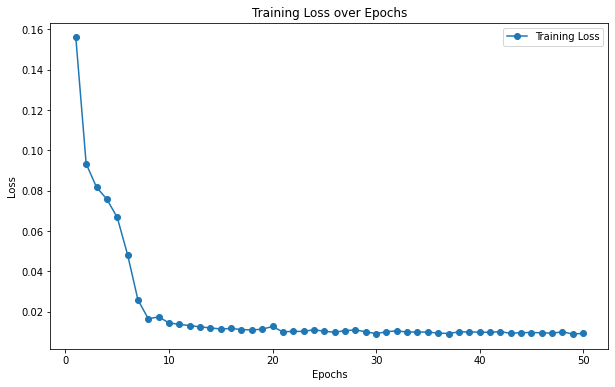

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

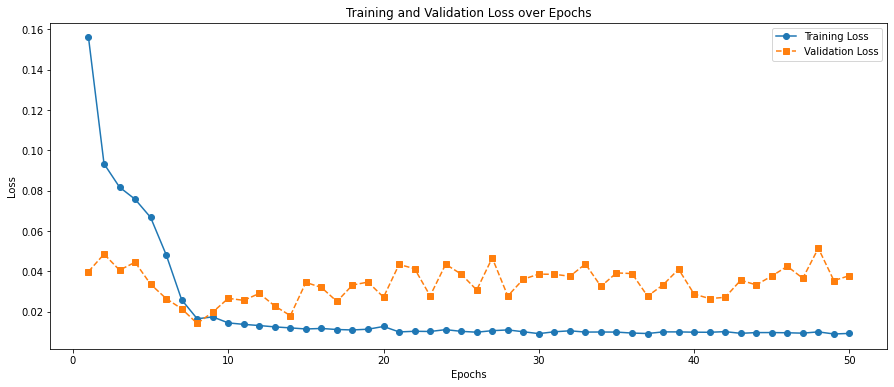

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.12028276205427801
MAE : 0.08924864171244426


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,326831.906250,49957.406
1,443897.218750,151973.751
2,466580.093750,466524.938
3,450961.750000,708542.184
4,394905.343750,652598.000
5,304842.906250,414216.785
6,194094.406250,236263.303
7,72538.187500,43422.368
8,-9366.270508,2161.744
9,-11060.086914,944.181


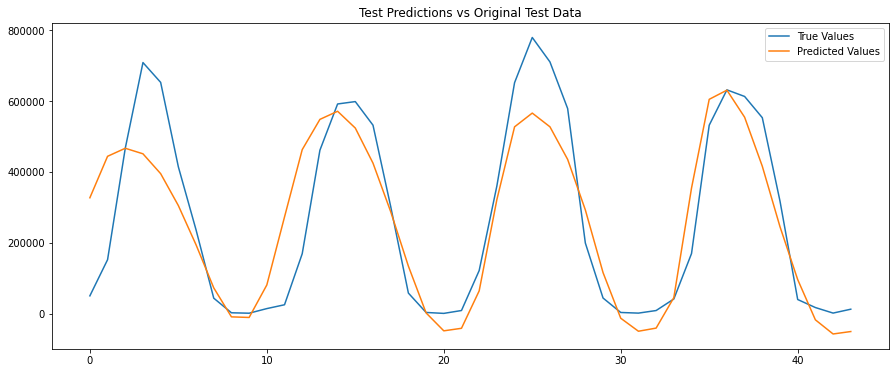

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 29ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

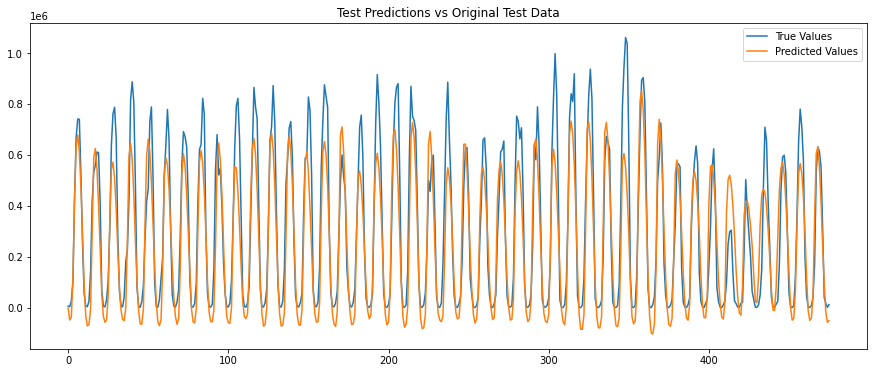

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()